In [48]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import dlsim, butter, lfilter, welch
import scienceplots

from cvxpygen import cpg

from functions import *

In [49]:
np.set_printoptions(suppress=True)
np.set_printoptions(precision=4)
plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '100'})

## Step excitation data from testbench

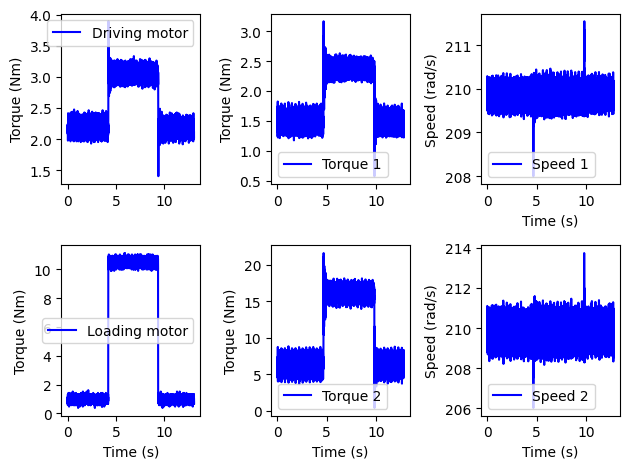

In [50]:
# Error correction
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

# The motor dataset columns:
# | time | motor setpoint | motor | propeller setpoint | propeller |
motor_data_step = np.loadtxt("../data/masters_data2/step_motor.csv", delimiter=",")

# The sensor dataset columns:
# | time | speed1 (encoder1) | speed2 (encoder2) | torque1 | torque2 |
sensor_data_step = np.loadtxt("../data/masters_data2/step_sensor.csv", delimiter=",")

plt.subplot(231)
plt.plot(motor_data_step[:,0], motor_data_step[:,2], label='Driving motor', color='blue')
plt.ylabel('Torque (Nm)')
plt.legend()

plt.subplot(234)
plt.plot(motor_data_step[:,0], motor_data_step[:,4], label='Loading motor', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.legend()

plt.subplot(232)
plt.plot(sensor_data_step[:,0], sensor_data_step[:,3], label='Torque 1', color='blue')
plt.ylabel('Torque (Nm)')
plt.legend()

plt.subplot(235)
plt.plot(sensor_data_step[:,0], sensor_data_step[:,4], label='Torque 2', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.legend()

plt.subplot(233)
plt.plot(sensor_data_step[:,0], sensor_data_step[:,1], label='Speed 1', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Speed (rad/s)')
plt.legend()

plt.subplot(236)
plt.plot(sensor_data_step[:,0], sensor_data_step[:,2], label='Speed 2', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Speed (rad/s)')
plt.legend()

plt.tight_layout()
plt.show()

(12867, 5)
0
1
2
3


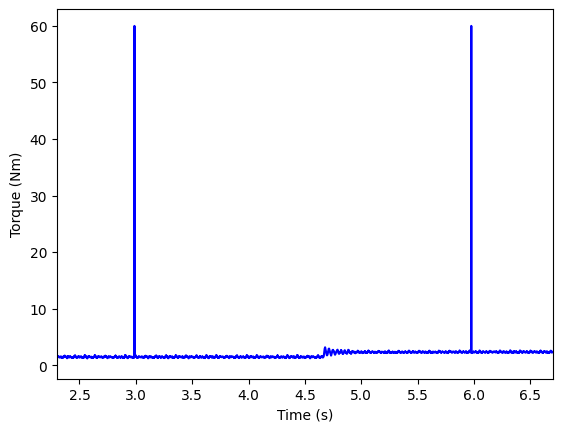

In [51]:
# add outliers to measurements
print(sensor_data_step.shape)
for i in range(int(sensor_data_step.shape[0] / 3000)):
    print(i)
    sensor_data_step[i*3000, 3] = 60
plt.plot(sensor_data_step[:,0], sensor_data_step[:,3], 'b-')
plt.xlim(2.3,6.7)
plt.xlabel("Time (s)")
plt.ylabel("Torque (Nm)")
# plt.savefig("notebook_figures/outlier_measurements.pdf")
plt.show()

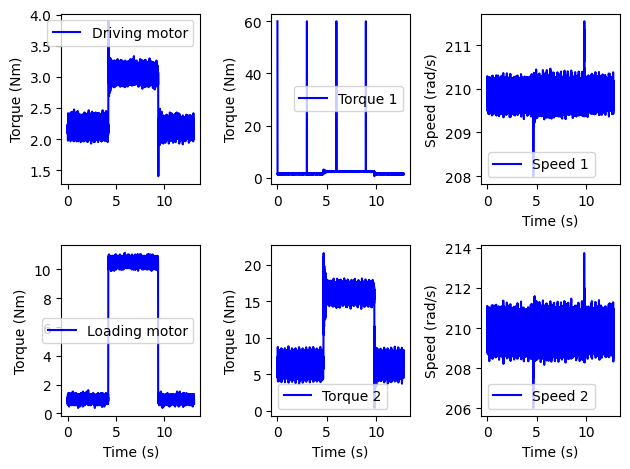

In [52]:
plt.subplot(231)
plt.plot(motor_data_step[:,0], motor_data_step[:,2], label='Driving motor', color='blue')
plt.ylabel('Torque (Nm)')
plt.legend()

plt.subplot(234)
plt.plot(motor_data_step[:,0], motor_data_step[:,4], label='Loading motor', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.legend()

plt.subplot(232)
plt.plot(sensor_data_step[:,0], sensor_data_step[:,3], label='Torque 1', color='blue')
plt.ylabel('Torque (Nm)')
plt.legend()

plt.subplot(235)
plt.plot(sensor_data_step[:,0], sensor_data_step[:,4], label='Torque 2', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.legend()

plt.subplot(233)
plt.plot(sensor_data_step[:,0], sensor_data_step[:,1], label='Speed 1', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Speed (rad/s)')
plt.legend()

plt.subplot(236)
plt.plot(sensor_data_step[:,0], sensor_data_step[:,2], label='Speed 2', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Speed (rad/s)')
plt.legend()

plt.tight_layout()
plt.show()

## Initiate data and state-space model

In [53]:
time = sensor_data_step[:,0]
measurements = sensor_data_step[:,1:] # measurement data from the encoder 1, encoder 2, torque transducer 1 and torque transducer 2
motors = np.vstack((motor_data_step[:,2], motor_data_step[:,4])).T # motor torque data

In [54]:
dt = np.mean(np.diff(time))
A, B, C, D = get_testbench_state_space(dt)
ss = (A, B, C, D)

In [55]:
# include second torque transducer to the observation matrix
C_mod = np.insert(C, 3, np.zeros((1, C.shape[1])), 0)
C_mod[3,22+18] += 2e4
D_mod = np.zeros((C_mod.shape[0], B.shape[1]))

# Batch size and overlap

In [56]:
# HP STEP
# measurement data from the encoder 1, encoder 2 and torque transducer 1 & 2
measurements_step = sensor_data_step[:,1:]

##########################################
batch_size = 100
overlap = 50
##########################################

input_estimates_step = weighted_ell2_analytical(
    ss, measurements_step[:,:-1], batch_size, overlap=overlap, lam=1, use_trend_filter=True
)

In [57]:
motor_input_step_est, propeller_input_step_est = process_estimates(n_batches=len(input_estimates_step), overlap=overlap, estimates=input_estimates_step, nstates=0)

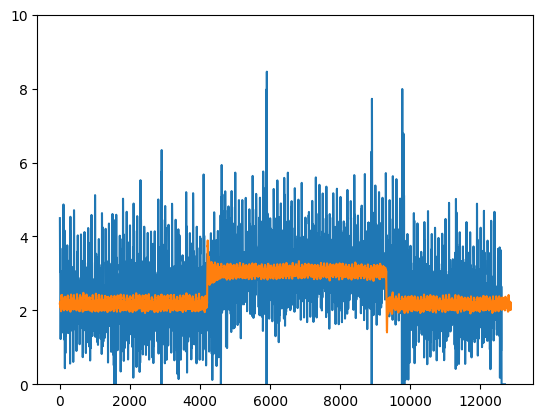

In [58]:
%matplotlib inline
plt.ylim(0,10)
plt.plot(motor_input_step_est[100:])
plt.plot(motor_data_step[:,2])
plt.show()


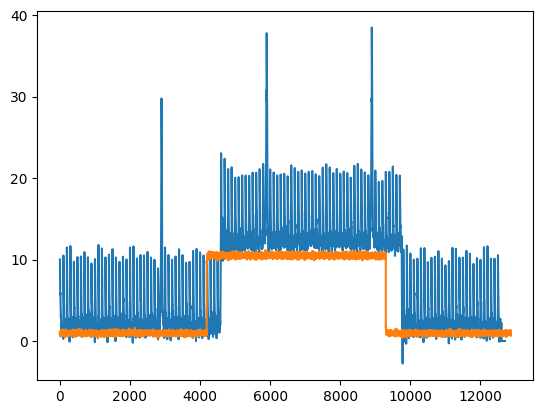

In [59]:
%matplotlib inline
plt.plot(propeller_input_step_est[100:])
plt.plot(motor_data_step[:,4])
plt.show()

## SVM input outlier filtering

In [60]:

### SVM outlier filtering
import time 

def cvxpygen_svm_reconstruction(ss, measurements, batch_size, overlap=50, lam=0.1, eps=1, use_trend_filter=False):
    """
    Analytical solution of the l2 regularized LS problem.
    Minimizes the sum of squared residuals, including an l2 constraint and known covariance for input and output.
    Initial state is always assumed zero.
    """
    n = measurements.shape[0]
    bs = batch_size + 2*overlap
    loop_len = int(n/batch_size)

    A, B, C, D = ss  # state space model
    O_mat, G, D2, L = get_data_equation_matrices(A, B, C, D, n, bs)  # data equation matrices

    if use_trend_filter: regul = D2 # regularization matrix
    else:                regul = L

    # define optimization variables
    uhat_svm = cp.Variable((G.shape[1],1))
    xi       = cp.Variable((G.shape[0], 1))
    xi_ast   = cp.Variable((G.shape[0], 1))

    objective = cp.Minimize(cp.sum_squares(regul @ uhat_svm) + lam*cp.norm1(xi + xi_ast))

    y_param = cp.Parameter((G.shape[0], uhat_svm.shape[1]), name='y')
    
    print(f"G shape = {G.shape} uhat =  {uhat_svm.shape}, thus y shape = {(G.shape[0], uhat_svm.shape[1])}")
    
    constraints = [
        y_param - G @ uhat_svm <= eps + xi,
        G @ uhat_svm - y_param <= eps + xi_ast,
        xi >= 0,
        xi_ast >= 0
    ]
    prob = cp.Problem(objective, constraints)

    input_estimates = []

    cpg.generate_code(prob, code_dir='nonneg_LS', solver='SCS')

    #  this is imported here as it gets generated at the above line
    from nonneg_LS.cpg_solver import cpg_solve
    
    t0 = time.time()

    for i in range(loop_len):

        if i == 0:              batch = measurements[:bs,:]
        elif i == loop_len-1:   batch = np.zeros((bs, measurements.shape[1])) # zero padding to finish estimation loop correctly
        else:                   batch = measurements[i*batch_size-overlap:(i+1)*batch_size+overlap,:]

        y = batch.reshape(-1,1)
        print(y.shape)
        y_param.value = y

        print("prob solved ", i)

        prob.register_solve('cpg', cpg_solve)
        
        prob.solve(method='cpg', updated_params=['y'], verbose=False)

        estimate = uhat_svm.value

        input_estimates.append(estimate)
    
    t1 = time.time()
    
    print(f'\n CVXPYgen Solve time: {(1000 * (t1 - t0))} ms\n')

    return input_estimates




In [61]:
# create bounds
lam = 0.01
eps = 0.01

svm_step_input_est = cvxpygen_svm_reconstruction(
    ss, measurements_step[:,:-1], batch_size, overlap=overlap, lam=lam, eps=eps, use_trend_filter=True
)

G shape = (600, 400) uhat =  (400, 1), thus y shape = (600, 1)
Generating code with CVXPYgen ...
CVXPYgen finished generating code.
Compiling python wrapper with CVXPYgen ... 
CVXPYgen finished compiling python wrapper.
(600, 1)
prob solved  0
(600, 1)
prob solved  1
(600, 1)
prob solved  2
(600, 1)
prob solved  3
(600, 1)
prob solved  4
(600, 1)
prob solved  5
(600, 1)
prob solved  6
(600, 1)
prob solved  7
(600, 1)
prob solved  8
(600, 1)
prob solved  9
(600, 1)
prob solved  10
(600, 1)
prob solved  11
(600, 1)
prob solved  12
(600, 1)
prob solved  13
(600, 1)
prob solved  14
(600, 1)
prob solved  15
(600, 1)
prob solved  16
(600, 1)
prob solved  17
(600, 1)
prob solved  18
(600, 1)
prob solved  19
(600, 1)
prob solved  20
(600, 1)
prob solved  21
(600, 1)
prob solved  22
(600, 1)
prob solved  23
(600, 1)
prob solved  24
(600, 1)
prob solved  25
(600, 1)
prob solved  26
(600, 1)
prob solved  27
(600, 1)
prob solved  28
(600, 1)
prob solved  29
(600, 1)
prob solved  30
(600, 1)
prob s

In [62]:
motor_input_svm, propeller_input_svm = process_estimates(len(svm_step_input_est), overlap, svm_step_input_est, nstates=0)

In [63]:
len(motor_input_svm), len(propeller_input_svm)

(12800, 12800)

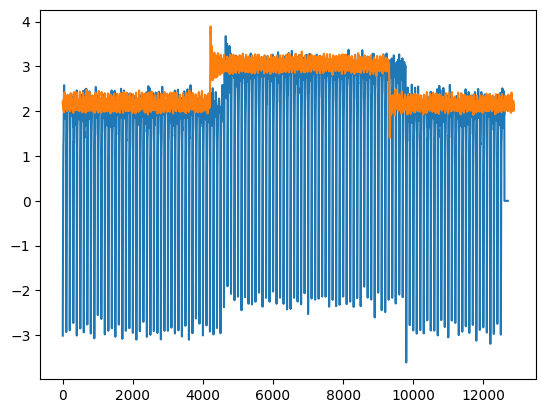

In [64]:
%matplotlib inline
plt.plot(motor_input_svm[100:])
plt.plot(motor_data_step[:,2])
plt.show()

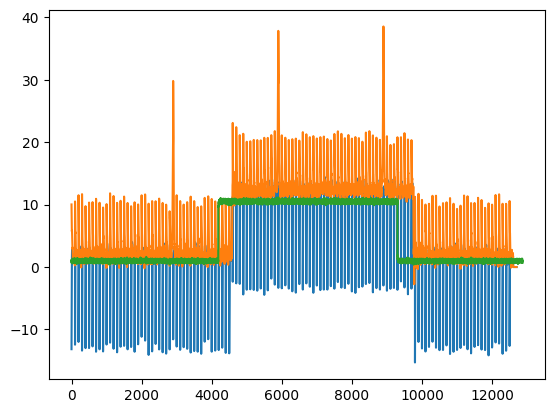

In [65]:
%matplotlib inline
plt.plot(propeller_input_svm[100:])
plt.plot(propeller_input_step_est[100:])
plt.plot(motor_data_step[:,4])
plt.show()

In [66]:
import pickle

with open('input_estimates_hp_svm.pkl', 'wb') as f:  # open a text file
    pickle.dump([motor_input_step_est, propeller_input_step_est, motor_input_svm, propeller_input_svm], f) # serialize the list
    
f.close()

In [67]:
with open('input_estimates_hp_svm.pkl', 'rb') as f:
    estimates_loaded = pickle.load(f) # deserialize using load()
motor_hp = estimates_loaded[0]
prop_hp = estimates_loaded[1]
motor_svm = estimates_loaded[2]
prop_svm = estimates_loaded[3]

In [68]:
U_est_hp = np.hstack((motor_hp, prop_hp))
U_est_svm = np.hstack((motor_svm, prop_svm))

In [69]:
time = sensor_data_step[:12500,0]
tout_hp, yout_hp, _ = dlsim((A, B, C_mod, D_mod, dt), U_est_hp[:len(time)], t=time)
tout_svm, yout_svm, _ = dlsim((A, B, C_mod, D_mod, dt), U_est_svm[:len(time)], t=time)

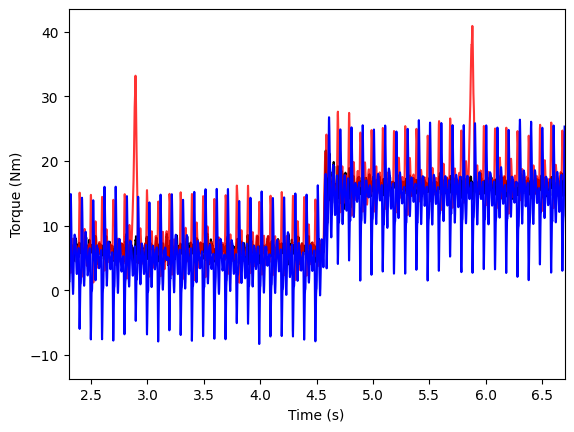

In [70]:
plt.plot(time[:-100], sensor_data_step[100:12500,4], 'k')
plt.plot(tout_hp[:-100], yout_hp[100:,-1], 'r-', alpha=0.8)
plt.plot(tout_svm[:-100], yout_svm[100:,-1], 'b-')
plt.xlim(2.3,6.7)
plt.xlabel("Time (s)")
plt.ylabel("Torque (Nm)")
# plt.savefig("notebook_figures/svm_step.pdf")
plt.show()